This notebook is a continuation off of the "medsam_hcp_predict_basics.ipynb" notebook. In this notebook, the MedSAM model is applied to more brain MRI slices
to show how this model does without any finetuning

In [1]:
import nibabel as nib
import numpy as np
print(np.__version__)

1.25.0


In [2]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    
    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [ ]:
#%% load model and image
MedSAM_CKPT_PATH = "/gpfs/home/kn2347/MedSAM/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

In [112]:
def show_example(id, slice_num, box, save_path = None, axis = 1):


    img = nib.load(f'/gpfs/data/cbi/hcp/hcp_seg/data_orig/{id}/mri/T1.mgz')
    img = img.get_fdata()
    img = np.take(img, indices = slice_num, axis = axis)
    img = np.repeat(img[:,:,None], 3, axis=-1).astype('uint8')
    x = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/pretrained_image_encoded_slices/{id}/{slice_num}.npy')
    y = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/segmentation_slices/{id}/seg_{slice_num}.npy')

    WIDTH = img.shape[1]
    HEIGHT = img.shape[0]

    if type(box) != 'np.ndarray':
        box = np.array([box])
    
    box_re = box / np.array([WIDTH, HEIGHT, WIDTH, HEIGHT]) * 1024
    x_tensor = torch.Tensor(x[None, :, : ,:]).to('cuda')
    res = medsam_inference(medsam_model.to('cuda'), x_tensor, box_re, H=256, W=256)

    #%% visualize results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    show_box(box[0], ax[0])
    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img)
    show_mask(res, ax[1])
    show_box(box[0], ax[1])
    ax[1].set_title("MedSAM Segmentation")
    

    fig.suptitle(f'id = {id}, slice = {slice_num}, bbox = {box}')

    if save_path is not None:
        #fig.savefig(f'{save_path}/{id}_{slice_num}_0.png')
        fig.savefig(save_path)
    plt.show()

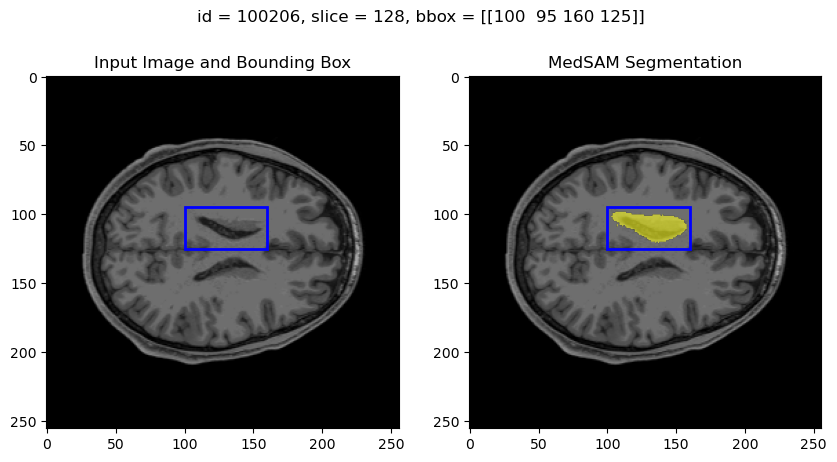

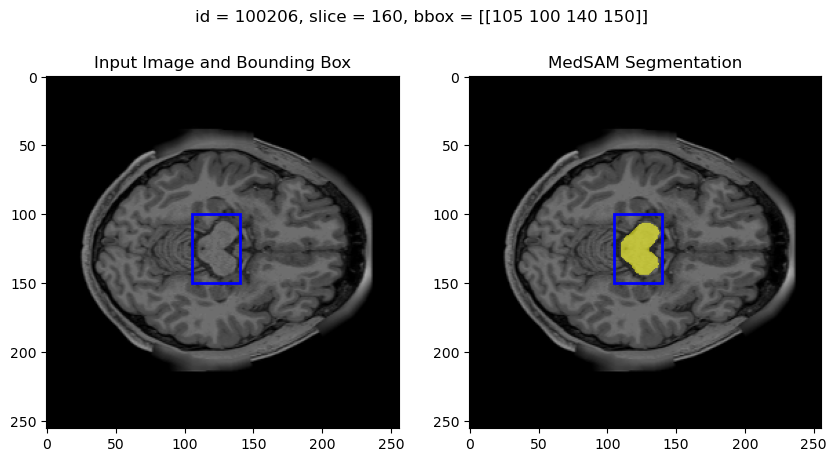

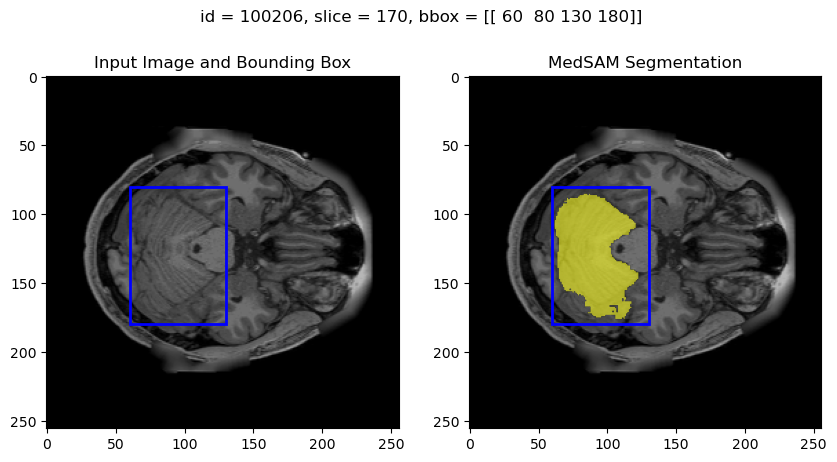

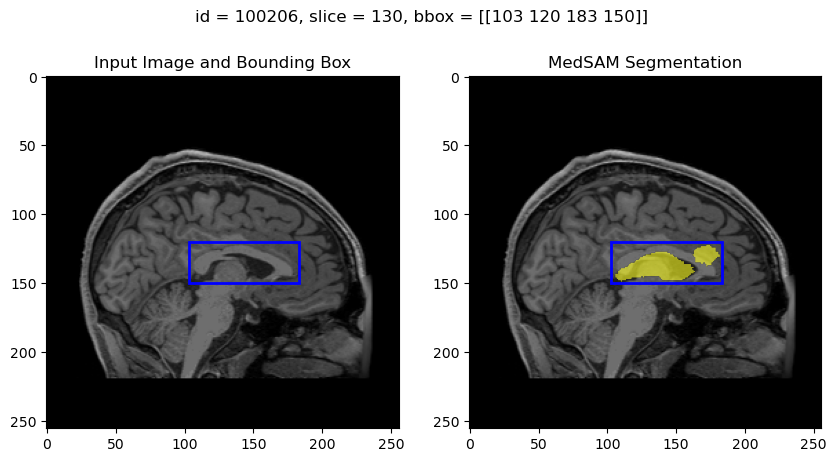

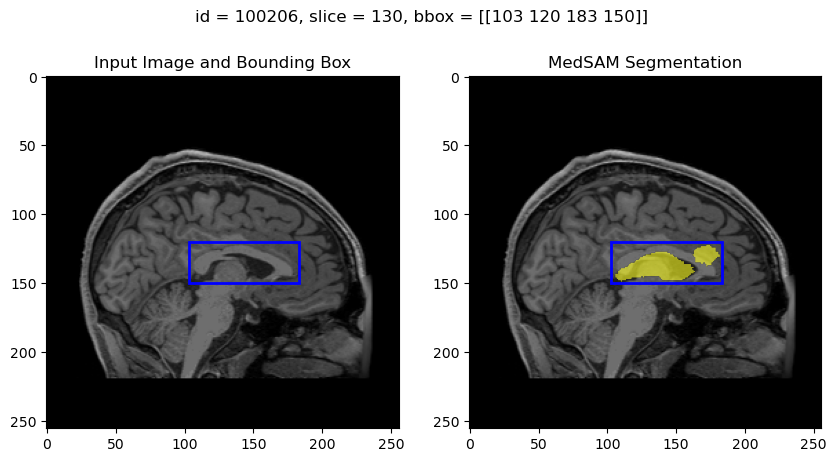

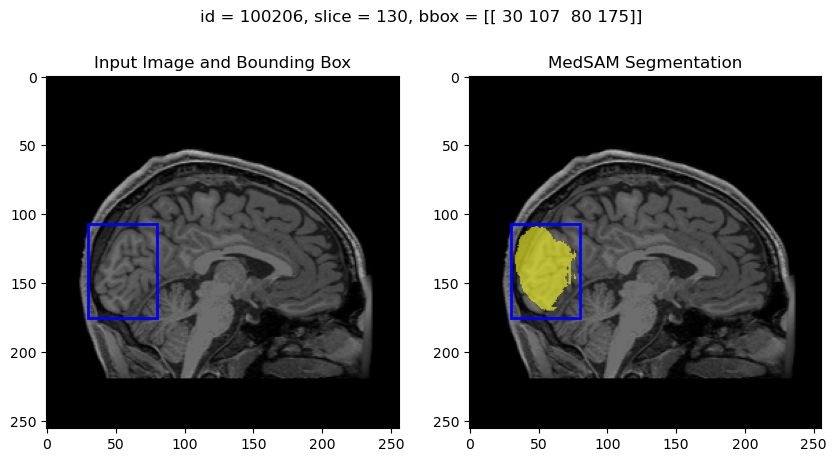

In [140]:
save_path = '/gpfs/home/kn2347/results/medsam_results/pretrained_hcp_segmentations_examples_7-17-23'



show_example('100206', 128, [100,95,160,125], save_path = f'{save_path}/100206_128_0.png') # left ventricle

show_example('100206', 160, [105,100,140,150], save_path = f'{save_path}/100206_160_0.png') # midbrain
show_example('100206', 170, [60,80,130,180], save_path = f'{save_path}/100206_170_0.png') # cerebellum
show_example('100206', 130, [103,120,183,150], save_path=f'{save_path}/100206_130_0_axis0.png', axis = 0) # corpus callosum
show_example('100206', 130, [30,107, 80,175], save_path=f'{save_path}/100206_130_2_axis0.png', axis = 0) # occipital

